## Importaciones y Configuración de Entorno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

# Configuración de visualización
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## Carga de Datos y Definición de Rutas

In [2]:
# Definición de rutas (ajustadas a la estructura del proyecto)
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'raw' / 'diamonds_train.csv'

# Carga del dataset
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
except FileNotFoundError:
    print("Error: No se encontró el archivo. Asegúrate de que esté en data/raw/diamonds_train.csv")

# Primer vistazo
df.head()

Dataset cargado con éxito. Dimensiones: (40455, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


## Inspección Técnica Inicial

In [3]:
# Información del dataset
print("--- Información General ---")
print(df.info())

print("\n--- Conteo de Valores Nulos ---")
print(df.isnull().sum())

print("\n--- Estadísticos Descriptivos ---")
display(df.describe())

--- Información General ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB
None

--- Conteo de Valores Nulos ---
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

--- Estadísticos Descriptivos ---


,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797706,61.752841,57.446133,3928.444469,5.729392,5.732819,3.537154
std,0.475544,1.431725,2.233535,3992.416147,1.124453,1.146650,0.697062
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2397.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.035000
max,4.500000,79.000000,95.000000,18823.000000,10.230000,58.900000,8.060000


## Análisis del Target (Precio)

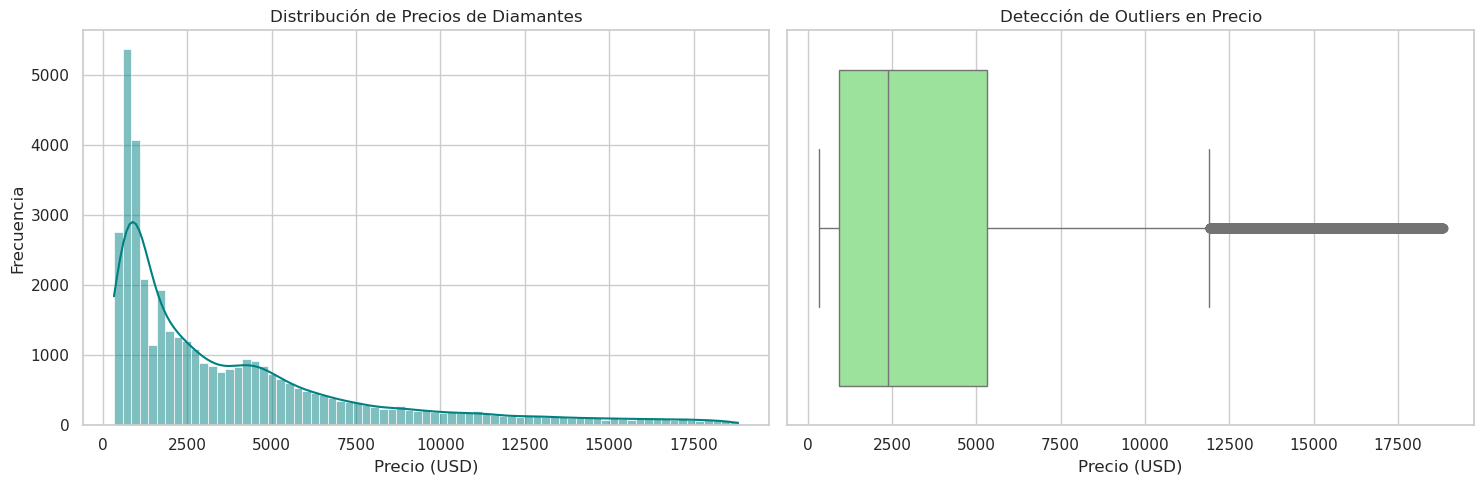

💰 Precio Mediano: $2,397.00
💰 Precio Promedio: $3,928.44


In [4]:
plt.figure(figsize=(15, 5))

# Subplot 1: Histograma de Precios
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, color='teal')
plt.title('Distribución de Precios de Diamantes')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')

# Subplot 2: Boxplot de Precios
plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'], color='lightgreen')
plt.title('Detección de Outliers en Precio')
plt.xlabel('Precio (USD)')

plt.tight_layout()
plt.show()

print(f"💰 Precio Mediano: ${df['price'].median():,.2f}")
print(f"💰 Precio Promedio: ${df['price'].mean():,.2f}")

## La relación Rey (Carat vs Price)

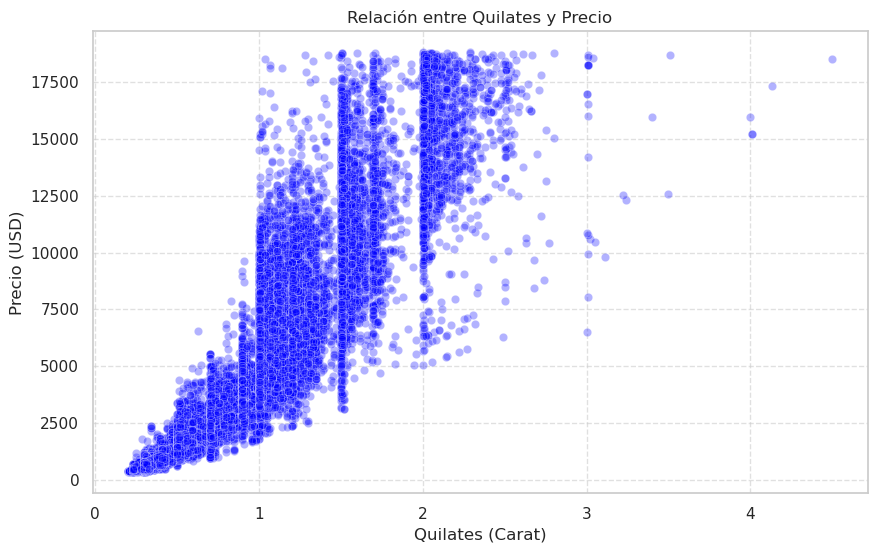

📈 Correlación de Pearson entre Carat y Price: 0.9219


In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='carat', y='price', alpha=0.3, color='blue')
plt.title('Relación entre Quilates y Precio')
plt.xlabel('Quilates (Carat)')
plt.ylabel('Precio (USD)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Correlación numérica
corr_carat = df['carat'].corr(df['price'])
print(f"📈 Correlación de Pearson entre Carat y Price: {corr_carat:.4f}")

## Análisis de Calidad (Categorías Ordinales)

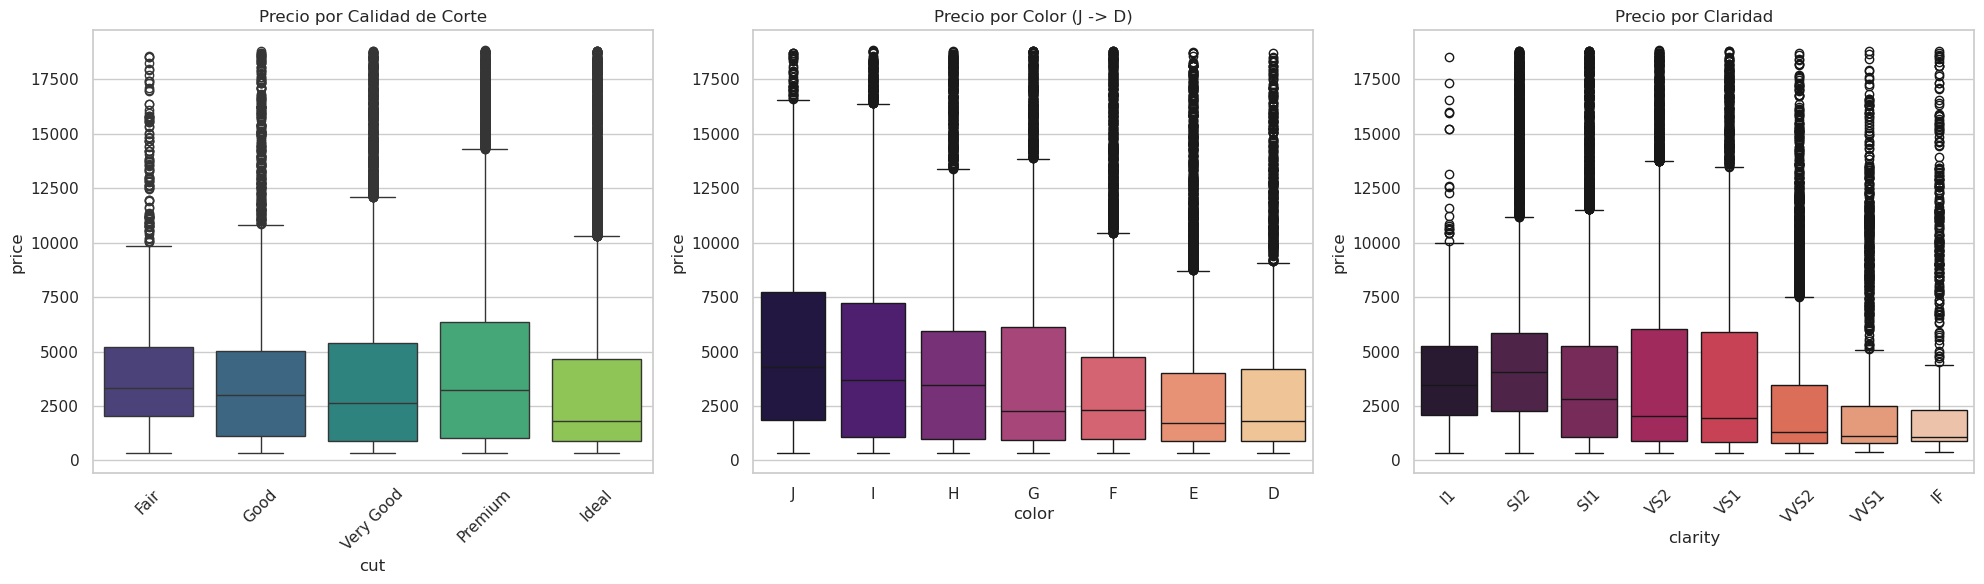

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Precio vs Corte
sns.boxplot(ax=axes[0], data=df, x='cut', y='price', palette='viridis', 
            order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
axes[0].set_title('Precio por Calidad de Corte')
axes[0].tick_params(axis='x', rotation=45)

# 2. Precio vs Color
sns.boxplot(ax=axes[1], data=df, x='color', y='price', palette='magma',
            order=['J', 'I', 'H', 'G', 'F', 'E', 'D'])
axes[1].set_title('Precio por Color (J -> D)')

# 3. Precio vs Claridad
sns.boxplot(ax=axes[2], data=df, x='clarity', y='price', palette='rocket',
            order=['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'])
axes[2].set_title('Precio por Claridad')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Análisis de Dimensiones y Outliers (x, y, z)

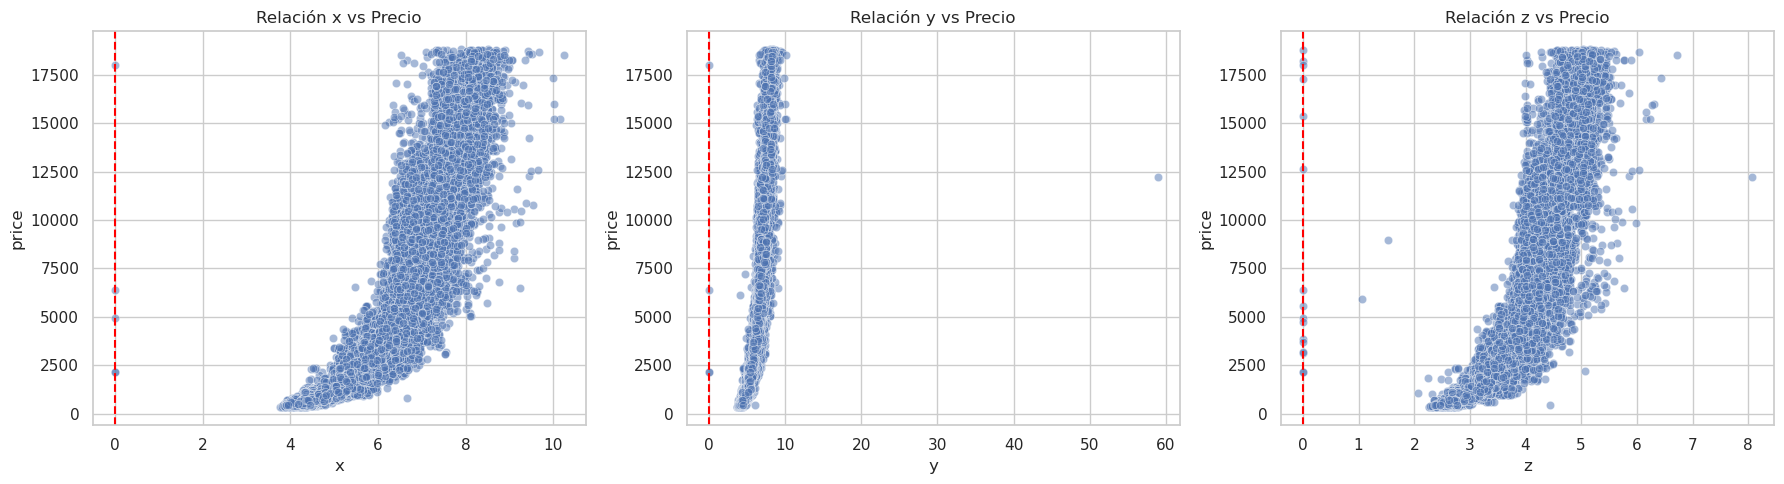

💎 Conteo de dimensiones con valor 0 (Inválidos):
X: 5 | Y: 4 | Z: 16


In [7]:
# Scatter plots de dimensiones vs Precio
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['x', 'y', 'z']):
    sns.scatterplot(ax=axes[i], data=df, x=col, y='price', alpha=0.5)
    axes[i].set_title(f'Relación {col} vs Precio')
    axes[i].axvline(0, color='red', linestyle='--') # Línea de peligro en 0

plt.tight_layout()
plt.show()

# Conteo de valores en cero
print("💎 Conteo de dimensiones con valor 0 (Inválidos):")
print(f"X: {(df.x == 0).sum()} | Y: {(df.y == 0).sum()} | Z: {(df.z == 0).sum()}")

## Matriz de Correlación (Heatmap)

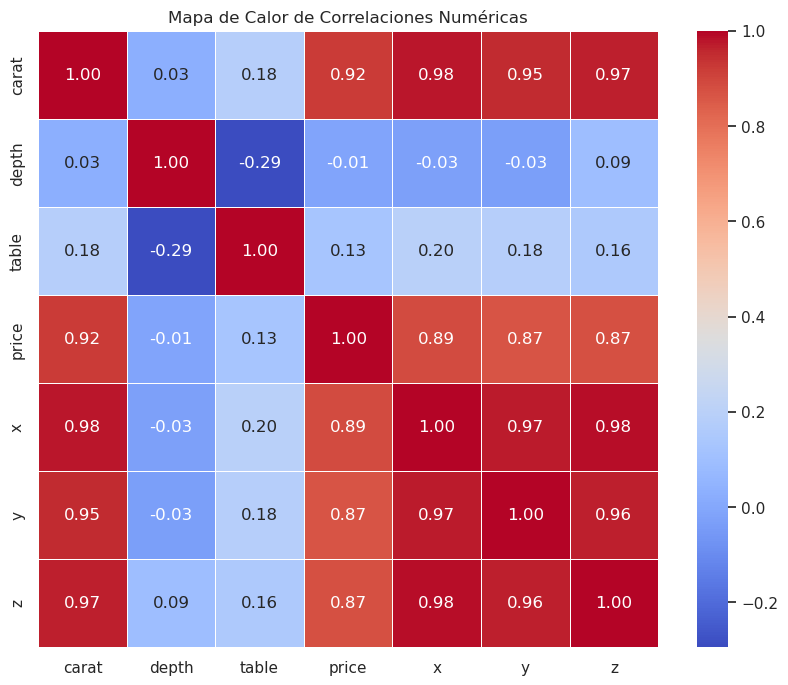

In [8]:
# Seleccionamos solo las variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones Numéricas')
plt.show()

## Preparación para el Modelado (Mini-Pipeline)

In [9]:
# 1. Limpieza rápida (eliminando ceros detectados en el EDA)
df_clean = df[(df.x > 0) & (df.y > 0) & (df.z > 0)].copy()

# 2. Definición de Features y Target
X = df_clean.drop('price', axis=1)
y = df_clean['price']

# 3. Encoding manual (respetando la jerarquía que vimos en los boxplots)
cut_categories = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_categories = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_categories = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

encoder = OrdinalEncoder(categories=[cut_categories, color_categories, clarity_categories])
X[['cut', 'color', 'clarity']] = encoder.fit_transform(X[['cut', 'color', 'clarity']])

# 4. Split de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Datos listos para la comparativa. Training set: {X_train.shape}")

✅ Datos listos para la comparativa. Training set: (32351, 9)


## Comparativa de Modelos (The Battle Royale)

In [10]:
# Definición de modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
}

model_results = []

print("🚀 Iniciando entrenamiento comparativo...\n")

for name, model in models.items():
    start_time = time.time()
    
    # Entrenamiento
    model.fit(X_train, y_train)
    
    # Predicción
    preds = model.predict(X_test)
    
    # Cálculo de métricas
    duration = time.time() - start_time
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    model_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2,
        "Training Time (s)": duration
    })
    
    print(f"✅ {name} completado.")

# Creación de DataFrame de resultados
df_comparison = pd.DataFrame(model_results).sort_values(by="MAE")
display(df_comparison)

🚀 Iniciando entrenamiento comparativo...

✅ Linear Regression completado.
✅ Random Forest completado.
✅ XGBoost completado.


,Model,MAE,RMSE,R2 Score,Training Time (s)
2,XGBoost,264.742198,538.228077,0.981976,82.286617
1,Random Forest,270.809014,551.444669,0.981080,0.621518
0,Linear Regression,807.299935,1762.180170,0.806799,0.035456


## Visualización Final de Errores

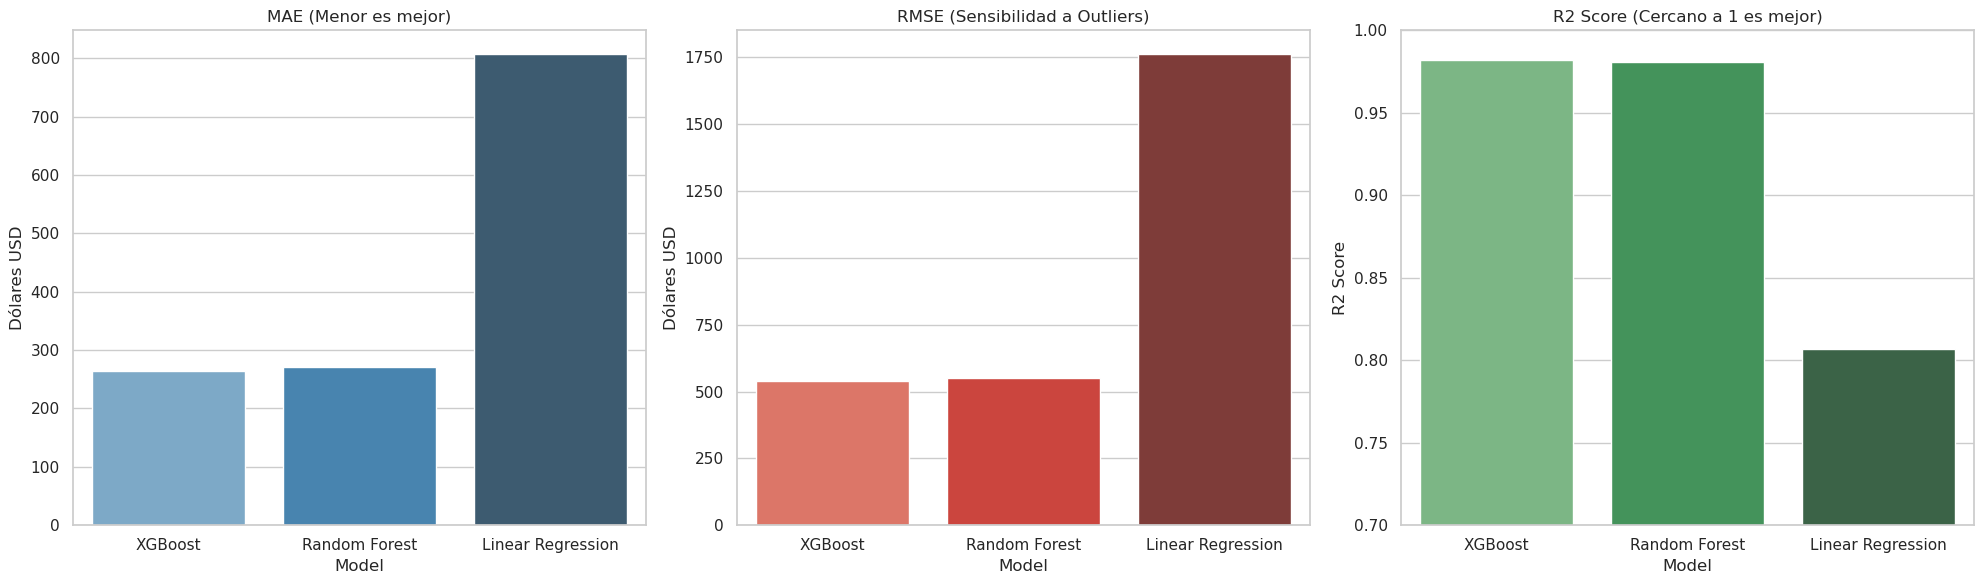

In [11]:
# Configuración de la figura para mostrar 3 métricas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Comparativa de MAE
sns.barplot(ax=axes[0], data=df_comparison, x="Model", y="MAE", palette="Blues_d")
axes[0].set_title("MAE (Menor es mejor)")
axes[0].set_ylabel("Dólares USD")

# 2. Comparativa de RMSE
sns.barplot(ax=axes[1], data=df_comparison, x="Model", y="RMSE", palette="Reds_d")
axes[1].set_title("RMSE (Sensibilidad a Outliers)")
axes[1].set_ylabel("Dólares USD")

# 3. Comparativa de R2 Score
sns.barplot(ax=axes[2], data=df_comparison, x="Model", y="R2 Score", palette="Greens_d")
axes[2].set_title("R2 Score (Cercano a 1 es mejor)")
axes[2].set_ylim(0.7, 1.0) # Zoom para apreciar la diferencia

plt.tight_layout()
plt.show()

## 🏁 Conclusiones de la Comparativa

Tras evaluar tres arquitecturas distintas, los resultados arrojan una jerarquía clara en el rendimiento:

1. **XGBoost como Ganador Indiscutible:** * Logra el **MAE más bajo ($264.74)**, reduciendo el error de la Regresión Lineal en casi un **67%**.
    * Su **R² de 0.982** confirma que captura casi la totalidad de la varianza del precio de los diamantes.
    * Aunque el tiempo de entrenamiento es mayor (82s), la ganancia en precisión justifica plenamente su uso en producción dentro de **ModelOps-Forge**.

2. **Random Forest (Competidor Cercano):** * Presenta un rendimiento muy sólido (**MAE: $270.80**), quedando apenas un 2% por detrás de XGBoost.
    * Su ventaja es la rapidez de entrenamiento (0.62s), pero en este dominio priorizamos la precisión por dólar que ofrece XGBoost.

3. **Regresión Lineal (Baseline insuficiente):** * Con un **MAE de $807.30**, este modelo simplifica demasiado el problema. El error es tres veces superior al de los modelos de ensamble, lo que demuestra que la relación entre las dimensiones y el precio no es lineal.

**Decisión Final:** Se procede con la implementación de **XGBoost** en el pipeline principal (`main.py`) y el script de inferencia, garantizando así la tasación más precisa posible para el usuario final.